In [1]:
import numpy as np
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
# import wfdb
# import biosignalsnotebooks as bsnb
# from wfdb import processing
from matplotlib import pyplot as plt
# from scipy import signal
# from biosppy.signals import ecg
np.set_printoptions(threshold=sys.maxsize)
import umap
import sklearn.utils as slu
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
kfold = StratifiedKFold(n_splits = 6,shuffle= True ,random_state =48)

In [3]:
def perform_metrics(clf_name, acc_list, pre_list, rec_list, f1_list, conf_list):
  acc_mean = round(np.mean(acc_list),3)
  acc_std = round(stdev(acc_list),3)
  pre_mean = round(np.mean(pre_list),3)
  pre_std = round(stdev(pre_list),3)
  rec_mean = round(np.mean(rec_list),3)
  rec_std = round(stdev(rec_list),3)
  f1_mean = round(np.mean(f1_list),3)
  f1_std = round(stdev(f1_list),3)
  print('Classifier Name: ',clf_name)
  print('accuracy mean: ',acc_mean,' std: ',acc_std)
  print('precision: ',pre_mean,' std: ',pre_std)
  print('recall: ',rec_mean,' std: ',rec_std)
  print('f1score: ',f1_mean,' std: ',f1_std)

  conf_list = np.nan_to_num(conf_list)
  conf = np.mean(conf_list,axis=0)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories)
  plt.title(clf_name + ' confusion matrix')
  return (clf_name,acc_mean,acc_std,pre_mean,pre_std,rec_mean,rec_std,f1_mean,f1_std)

In [4]:
path = '/content/drive/MyDrive/ecg/'

##Unsampled

In [ ]:
mlii = np.loadtxt(path+'train_unsampled_mlii/mlii.csv', delimiter=',')
print(mlii.shape)

In [ ]:
np.random.shuffle(mlii)

X = mlii[:,:-3]
y = mlii[:,-3]
print(X.shape, y.shape)

In [ ]:
inputs = X
targets = y
categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']

In [ ]:
cnn_acc_list = []
cnn_pre_list = []
cnn_rec_list = []
cnn_f1_list = []
cnn_conf_list = []

xgb_acc_list = []
xgb_pre_list = []
xgb_rec_list = []
xgb_f1_list = []
xgb_conf_list = []

from sklearn.utils import resample
from xgboost import XGBClassifier

fold_no = 1

for train, test in kfold.split(inputs, targets):
  # N = train[targets[train]==1.0]
  # L = train[targets[train]==2.0]
  # R = train[targets[train]==3.0]
  # A = train[targets[train]==4.0]
  # V = train[targets[train]==5.0]
  # F = train[targets[train]==6.0]
  # f = train[targets[train]==7.0]
  # P = train[targets[train]==8.0]

  # seed = 42


  verbose, epoch, batch_size = 0, 10, 128
  inputs_3d = inputs.reshape(-1, inputs.shape[1],1)
  targets_cat = to_categorical(targets) 

  cnnmodel = Sequential()
  cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(inputs_3d.shape[1],inputs_3d.shape[2])))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Dropout(rate=0.2))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(64, activation='relu'))
  cnnmodel.add(Dense(32, activation='relu'))
  cnnmodel.add(Dense(9, activation='softmax'))
  cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('CNN, Fold number: ', fold_no)
  model = cnnmodel.fit(inputs_3d[train], targets_cat[train], epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)
  cnnpredictions = cnnmodel.predict(inputs_3d[test], verbose=1)
  y_pred_cnn = np.argmax(cnnpredictions, axis=1)
  cnn_actual = np.argmax(targets_cat[test], axis=1)

  cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
  cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
  cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
  cnn_conf_list.append(cnn_cm)



  print('XGB, Fold number: ', fold_no)
  model = XGBClassifier()
  model.fit(inputs[train], targets[train],verbose=2)


  y_pred_xgb = model.predict(inputs[test])
  
  xgb_acc_list.append(accuracy_score(targets[test], y_pred_xgb))
  xgb_pre_list.append(precision_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_rec_list.append(recall_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_f1_list.append(f1_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_cm = confusion_matrix(targets[test], y_pred_xgb)
  xgb_cm = xgb_cm.astype('float')/ xgb_cm.sum(axis=1)[:,np.newaxis]
  xgb_conf_list.append(xgb_cm)

  fold_no +=1


In [ ]:
CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)
XGB_results = perform_metrics('XGB', xgb_acc_list, xgb_pre_list, xgb_rec_list, xgb_f1_list, xgb_conf_list)

In [ ]:
crossval_results = pd.DataFrame(data = (CNN_results, XGB_results))

In [ ]:
if not os.path.exists(path + 'metric_results/unsampled'):
  os.makedirs(path + 'metric_results/unsampled')

In [ ]:
print(crossval_results)
crossval_results.to_csv(path + 'metric_results/unsampled/crossval_results.csv', encoding='utf-8', index=False)

In [ ]:
if not os.path.exists(path + 'metric_results/unsampled/cnn'):
  os.makedirs(path + 'metric_results/unsampled/cnn')

In [ ]:
cnn_unsamp = path + 'metric_results/unsampled/cnn/'
CNN_acc = pd.DataFrame(cnn_acc_list)
CNN_acc.to_csv(cnn_unsamp + 'CNN_acc.csv', encoding='utf-8', index=False)

CNN_pre = pd.DataFrame(cnn_pre_list)
CNN_pre.to_csv(cnn_unsamp + 'CNN_pre.csv', encoding='utf-8', index=False)

CNN_rec = pd.DataFrame(cnn_rec_list)
CNN_rec.to_csv(cnn_unsamp +'CNN_rec.csv', encoding='utf-8', index=False)

CNN_f1s = pd.DataFrame(cnn_f1_list)
CNN_f1s.to_csv(cnn_unsamp +'CNN_f1s.csv', encoding='utf-8', index=False)

In [ ]:
if not os.path.exists(path + 'metric_results/unsampled/xgb'):
  os.makedirs(path + 'metric_results/unsampled/xgb')

In [ ]:
xgb_unsamp = path + 'metric_results/unsampled/xgb/'
XGB_acc = pd.DataFrame(xgb_acc_list)
XGB_acc.to_csv(xgb_unsamp + 'XGB_acc.csv', encoding='utf-8', index=False)

XGB_pre = pd.DataFrame(xgb_pre_list)
XGB_pre.to_csv(xgb_unsamp + 'XGB_pre.csv', encoding='utf-8', index=False)

XGB_rec = pd.DataFrame(xgb_rec_list)
XGB_rec.to_csv(xgb_unsamp +'XGB_rec.csv', encoding='utf-8', index=False)

XGB_f1s = pd.DataFrame(xgb_f1_list)
XGB_f1s.to_csv(xgb_unsamp +'XGB_f1s.csv', encoding='utf-8', index=False)

##VAE Synthetic Data Only

> Set the value of synth to the model chosen from below for cross validation classification of the synthetic data generated from that model.




In [ ]:
comb = path + 'synthetic_data/combined/'
cnn_synth = np.genfromtxt(comb + 'cnn_synth.csv', delimiter=',')
cnn_sparse_synth = np.genfromtxt(comb + 'cnn_sparse_synth.csv', delimiter=',' )
lstm_synth = np.genfromtxt(comb + 'lstm_synth.csv', delimiter=',')
lstm_sparse_synth = np.genfromtxt(comb + 'lstm_sparse_synth.csv', delimiter=',')

In [ ]:
print(cnn_synth.shape)
print(cnn_sparse_synth.shape)
print(lstm_synth.shape)
print(lstm_sparse_synth.shape)

In [ ]:
synth = cnn_sparse_synth

In [ ]:
np.random.shuffle(synth)

X = synth[:,:-1]
y = synth[:,-1]
print(X.shape, y.shape)

In [ ]:
inputs = X
targets = y
categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']

In [ ]:
cnn_acc_list = []
cnn_pre_list = []
cnn_rec_list = []
cnn_f1_list = []
cnn_conf_list = []

xgb_acc_list = []
xgb_pre_list = []
xgb_rec_list = []
xgb_f1_list = []
xgb_conf_list = []

from sklearn.utils import resample
from xgboost import XGBClassifier

fold_no = 1

for train, test in kfold.split(inputs, targets):
  # N = train[targets[train]==1.0]
  # L = train[targets[train]==2.0]
  # R = train[targets[train]==3.0]
  # A = train[targets[train]==4.0]
  # V = train[targets[train]==5.0]
  # F = train[targets[train]==6.0]
  # f = train[targets[train]==7.0]
  # P = train[targets[train]==8.0]

  # seed = 42


  verbose, epoch, batch_size = 0, 10, 128
  inputs_3d = inputs.reshape(-1, inputs.shape[1],1)
  targets_cat = to_categorical(targets) 

  cnnmodel = Sequential()
  cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(inputs_3d.shape[1],inputs_3d.shape[2])))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Dropout(rate=0.2))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(64, activation='relu'))
  cnnmodel.add(Dense(32, activation='relu'))
  cnnmodel.add(Dense(9, activation='softmax'))
  cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('CNN, Fold number: ', fold_no)
  model = cnnmodel.fit(inputs_3d[train], targets_cat[train], epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)
  cnnpredictions = cnnmodel.predict(inputs_3d[test], verbose=1)
  y_pred_cnn = np.argmax(cnnpredictions, axis=1)
  cnn_actual = np.argmax(targets_cat[test], axis=1)

  cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
  cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
  cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
  cnn_conf_list.append(cnn_cm)



  print('XGB, Fold number: ', fold_no)
  model = XGBClassifier()
  model.fit(inputs[train], targets[train],verbose=2)


  y_pred_xgb = model.predict(inputs[test])
  
  xgb_acc_list.append(accuracy_score(targets[test], y_pred_xgb))
  xgb_pre_list.append(precision_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_rec_list.append(recall_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_f1_list.append(f1_score(targets[test], y_pred_xgb, average='weighted'))
  xgb_cm = confusion_matrix(targets[test], y_pred_xgb)
  xgb_cm = xgb_cm.astype('float')/ xgb_cm.sum(axis=1)[:,np.newaxis]
  xgb_conf_list.append(xgb_cm)

  fold_no +=1


In [ ]:
CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)
XGB_results = perform_metrics('XGB', xgb_acc_list, xgb_pre_list, xgb_rec_list, xgb_f1_list, xgb_conf_list)

In [ ]:
crossval_results = pd.DataFrame(data = (CNN_results, XGB_results))

if not os.path.exists(path + 'metric_results/synthetic_cnn_sparse'):
  os.makedirs(path + 'metric_results/synthetic_cnn_sparse')

print(crossval_results)
crossval_results.to_csv(path + 'metric_results/synthetic_cnn_sparse/crossval_results.csv', encoding='utf-8', index=False)



In [ ]:
if not os.path.exists(path + 'metric_results/synthetic_cnn_sparse/cnn'):
  os.makedirs(path + 'metric_results/synthetic_cnn_sparse/cnn')

cnn_unsamp = path + 'metric_results/synthetic_cnn_sparse/cnn/'
CNN_acc = pd.DataFrame(cnn_acc_list)
CNN_acc.to_csv(cnn_unsamp + 'CNN_acc.csv', encoding='utf-8', index=False)

CNN_pre = pd.DataFrame(cnn_pre_list)
CNN_pre.to_csv(cnn_unsamp + 'CNN_pre.csv', encoding='utf-8', index=False)

CNN_rec = pd.DataFrame(cnn_rec_list)
CNN_rec.to_csv(cnn_unsamp +'CNN_rec.csv', encoding='utf-8', index=False)

CNN_f1s = pd.DataFrame(cnn_f1_list)
CNN_f1s.to_csv(cnn_unsamp +'CNN_f1s.csv', encoding='utf-8', index=False)

In [ ]:
if not os.path.exists(path + 'metric_results/synthetic_cnn_sparse/xgb'):
  os.makedirs(path + 'metric_results/synthetic_cnn_sparse/xgb')

xgb_unsamp = path + 'metric_results/synthetic_cnn_sparse/xgb/'
XGB_acc = pd.DataFrame(xgb_acc_list)
XGB_acc.to_csv(xgb_unsamp + 'XGB_acc.csv', encoding='utf-8', index=False)

XGB_pre = pd.DataFrame(xgb_pre_list)
XGB_pre.to_csv(xgb_unsamp + 'XGB_pre.csv', encoding='utf-8', index=False)

XGB_rec = pd.DataFrame(xgb_rec_list)
XGB_rec.to_csv(xgb_unsamp +'XGB_rec.csv', encoding='utf-8', index=False)

XGB_f1s = pd.DataFrame(xgb_f1_list)
XGB_f1s.to_csv(xgb_unsamp +'XGB_f1s.csv', encoding='utf-8', index=False)

## Sampled with SMOTE

In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
mlii = np.loadtxt(path+'train_unsampled_mlii/mlii.csv', delimiter=',')
print(mlii.shape)

(108828, 259)


In [7]:
np.random.shuffle(mlii)

X = mlii[:,:-3]
y = mlii[:,-3]
print(X.shape, y.shape)

(108828, 256) (108828,)


In [8]:
inputs = X
targets = y
categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']

In [9]:
def smote_rus(train_vals):
  X_train = train_vals[:,:-1]
  y_train = train_vals[:,-1]
  label_count = Counter(y_train)
  print(label_count)
  classes, counts = np.unique(y_train, return_counts=True)
  imbalanced = counts[1:]
  imb_max = np.max(imbalanced)
  print(imb_max)
  normal_count = counts[0]
  print(normal_count)

  samp_strat = {1:normal_count,2:imb_max,3:imb_max,4:imb_max,5:imb_max,6:imb_max,7:imb_max,8:imb_max}
  sm = SMOTE(random_state=42, sampling_strategy=samp_strat)
  X_bal, y_bal = sm.fit_resample(X_train,y_train)
  print(Counter(y_bal))

  rus = RandomUnderSampler()
  X_u,y_u = rus.fit_resample(X_bal,y_bal)
  print(Counter(y_u))

  return X_u, y_u

In [11]:
cnn_acc_list = []
cnn_pre_list = []
cnn_rec_list = []
cnn_f1_list = []
cnn_conf_list = []

xgb_acc_list = []
xgb_pre_list = []
xgb_rec_list = []
xgb_f1_list = []
xgb_conf_list = []

from sklearn.utils import resample
from xgboost import XGBClassifier

fold_no = 1

for train, test in kfold.split(inputs, targets):

  xtr, xte = inputs[train], inputs[test]
  ytr, yte = targets[train], targets[test]

  ytr_res = ytr.reshape(-1,1)

  train_vals = np.concatenate((xtr, ytr_res), axis=1)

  xtr_new, ytr_new = smote_rus(train_vals)  


  verbose, epoch, batch_size = 0, 10, 128
  inputs_3d_tr = xtr_new.reshape(-1, xtr_new.shape[1],1)
  inputs_3d_te = xte.reshape(-1, xte.shape[1],1)
  targets_cat_tr = to_categorical(ytr_new) 
  targets_cat_te = to_categorical(yte)

  cnnmodel = Sequential()
  cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(inputs_3d_tr.shape[1],inputs_3d_tr.shape[2])))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Dropout(rate=0.2))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(64, activation='relu'))
  cnnmodel.add(Dense(32, activation='relu'))
  cnnmodel.add(Dense(9, activation='softmax'))
  cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('CNN, Fold number: ', fold_no)
  model = cnnmodel.fit(inputs_3d_tr, targets_cat_tr, epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)
  cnnpredictions = cnnmodel.predict(inputs_3d_te, verbose=1)
  y_pred_cnn = np.argmax(cnnpredictions, axis=1)
  cnn_actual = np.argmax(targets_cat_te, axis=1)

  cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
  cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
  cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
  cnn_conf_list.append(cnn_cm)



  print('XGB, Fold number: ', fold_no)
  model = XGBClassifier()
  model.fit(xtr_new, ytr_new,verbose=2)


  y_pred_xgb = model.predict(xte)
  
  xgb_acc_list.append(accuracy_score(yte, y_pred_xgb))
  xgb_pre_list.append(precision_score(yte, y_pred_xgb, average='weighted'))
  xgb_rec_list.append(recall_score(yte, y_pred_xgb, average='weighted'))
  xgb_f1_list.append(f1_score(yte, y_pred_xgb, average='weighted'))
  xgb_cm = confusion_matrix(yte, y_pred_xgb)
  xgb_cm = xgb_cm.astype('float')/ xgb_cm.sum(axis=1)[:,np.newaxis]
  xgb_conf_list.append(xgb_cm)

  fold_no +=1


Counter({1.0: 62514, 2.0: 6727, 3.0: 6047, 5.0: 5941, 8.0: 5853, 4.0: 2120, 7.0: 819, 6.0: 669})
6727
62514


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62514, 8.0: 6727, 2.0: 6727, 5.0: 6727, 3.0: 6727, 6.0: 6727, 7.0: 6727, 4.0: 6727})
Counter({1.0: 6727, 2.0: 6727, 3.0: 6727, 4.0: 6727, 5.0: 6727, 6.0: 6727, 7.0: 6727, 8.0: 6727})
CNN, Fold number:  1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 1ms/step
XGB, Fold number:  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({1.0: 62514, 2.0: 6727, 3.0: 6046, 5.0: 5942, 8.0: 5853, 4.0: 2120, 7.0: 819, 6.0: 669})
6727
62514


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62514, 8.0: 6727, 5.0: 6727, 3.0: 6727, 2.0: 6727, 4.0: 6727, 7.0: 6727, 6.0: 6727})
Counter({1.0: 6727, 2.0: 6727, 3.0: 6727, 4.0: 6727, 5.0: 6727, 6.0: 6727, 7.0: 6727, 8.0: 6727})
CNN, Fold number:  2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 1ms/step
XGB, Fold number:  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({1.0: 62514, 2.0: 6727, 3.0: 6046, 5.0: 5942, 8.0: 5853, 4.0: 2120, 7.0: 818, 6.0: 670})
6727
62514


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62514, 8.0: 6727, 2.0: 6727, 5.0: 6727, 3.0: 6727, 4.0: 6727, 6.0: 6727, 7.0: 6727})
Counter({1.0: 6727, 2.0: 6727, 3.0: 6727, 4.0: 6727, 5.0: 6727, 6.0: 6727, 7.0: 6727, 8.0: 6727})
CNN, Fold number:  3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 1ms/step
XGB, Fold number:  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({1.0: 62514, 2.0: 6726, 3.0: 6047, 5.0: 5942, 8.0: 5854, 4.0: 2120, 7.0: 818, 6.0: 669})
6726
62514


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62514, 8.0: 6726, 2.0: 6726, 5.0: 6726, 4.0: 6726, 3.0: 6726, 6.0: 6726, 7.0: 6726})
Counter({1.0: 6726, 2.0: 6726, 3.0: 6726, 4.0: 6726, 5.0: 6726, 6.0: 6726, 7.0: 6726, 8.0: 6726})
CNN, Fold number:  4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 1ms/step
XGB, Fold number:  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({1.0: 62514, 2.0: 6726, 3.0: 6047, 5.0: 5942, 8.0: 5854, 4.0: 2120, 7.0: 818, 6.0: 669})
6726
62514


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62514, 8.0: 6726, 2.0: 6726, 5.0: 6726, 3.0: 6726, 4.0: 6726, 6.0: 6726, 7.0: 6726})
Counter({1.0: 6726, 2.0: 6726, 3.0: 6726, 4.0: 6726, 5.0: 6726, 6.0: 6726, 7.0: 6726, 8.0: 6726})
CNN, Fold number:  5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 1ms/step
XGB, Fold number:  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({1.0: 62515, 2.0: 6727, 3.0: 6047, 5.0: 5941, 8.0: 5853, 4.0: 2120, 7.0: 818, 6.0: 669})
6727
62515


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({1.0: 62515, 2.0: 6727, 8.0: 6727, 3.0: 6727, 5.0: 6727, 4.0: 6727, 6.0: 6727, 7.0: 6727})
Counter({1.0: 6727, 2.0: 6727, 3.0: 6727, 4.0: 6727, 5.0: 6727, 6.0: 6727, 7.0: 6727, 8.0: 6727})
CNN, Fold number:  6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


567/567 [==============================] - 1s 2ms/step
XGB, Fold number:  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier Name:  CNN
accuracy mean:  0.894  std:  0.007
precision:  0.889  std:  0.009
recall:  0.894  std:  0.007
f1score:  0.886  std:  0.007
Classifier Name:  XGB
accuracy mean:  0.927  std:  0.002
precision:  0.953  std:  0.002
recall:  0.927  std:  0.002
f1score:  0.936  std:  0.002


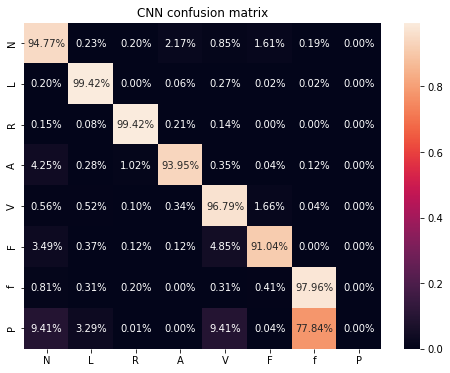

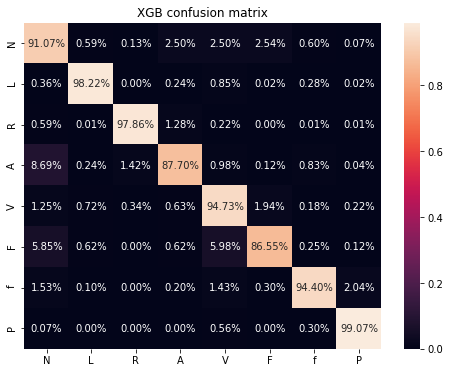

In [12]:
CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)
XGB_results = perform_metrics('XGB', xgb_acc_list, xgb_pre_list, xgb_rec_list, xgb_f1_list, xgb_conf_list)

In [13]:
crossval_results = pd.DataFrame(data = (CNN_results, XGB_results))

if not os.path.exists(path + 'metric_results/smote'):
  os.makedirs(path + 'metric_results/smote')

print(crossval_results)
crossval_results.to_csv(path + 'metric_results/smote/crossval_results.csv', encoding='utf-8', index=False)



     0      1      2      3      4      5      6      7      8
0  CNN  0.894  0.007  0.889  0.009  0.894  0.007  0.886  0.007
1  XGB  0.927  0.002  0.953  0.002  0.927  0.002  0.936  0.002


In [14]:
if not os.path.exists(path + 'metric_results/smote/cnn'):
  os.makedirs(path + 'metric_results/smote/cnn')

cnn_unsamp = path + 'metric_results/smote/cnn/'
CNN_acc = pd.DataFrame(cnn_acc_list)
CNN_acc.to_csv(cnn_unsamp + 'CNN_acc.csv', encoding='utf-8', index=False)

CNN_pre = pd.DataFrame(cnn_pre_list)
CNN_pre.to_csv(cnn_unsamp + 'CNN_pre.csv', encoding='utf-8', index=False)

CNN_rec = pd.DataFrame(cnn_rec_list)
CNN_rec.to_csv(cnn_unsamp +'CNN_rec.csv', encoding='utf-8', index=False)

CNN_f1s = pd.DataFrame(cnn_f1_list)
CNN_f1s.to_csv(cnn_unsamp +'CNN_f1s.csv', encoding='utf-8', index=False)

In [15]:
if not os.path.exists(path + 'metric_results/smote/xgb'):
  os.makedirs(path + 'metric_results/smote/xgb')

xgb_unsamp = path + 'metric_results/smote/xgb/'
XGB_acc = pd.DataFrame(xgb_acc_list)
XGB_acc.to_csv(xgb_unsamp + 'XGB_acc.csv', encoding='utf-8', index=False)

XGB_pre = pd.DataFrame(xgb_pre_list)
XGB_pre.to_csv(xgb_unsamp + 'XGB_pre.csv', encoding='utf-8', index=False)

XGB_rec = pd.DataFrame(xgb_rec_list)
XGB_rec.to_csv(xgb_unsamp +'XGB_rec.csv', encoding='utf-8', index=False)

XGB_f1s = pd.DataFrame(xgb_f1_list)
XGB_f1s.to_csv(xgb_unsamp +'XGB_f1s.csv', encoding='utf-8', index=False)

## Sampled with VAE Synthetic Data

In [ ]:
def downsample(arr,n,seed):
    downsampled = slu.resample(arr,replace=False,n_samples=n,random_state=seed)
    return downsampled

def resample_vae(train_vals, synth_model):
  # compute number of values per class
  anno = train_vals[:,-1]
  normal = train_vals[anno == 1.0]
  lbbb = train_vals[anno == 2.0]
  rbbb = train_vals[anno == 3.0]
  apb = train_vals[anno == 4.0]
  pvc = train_vals[anno == 5.0]
  fvn = train_vals[anno == 6.0]
  fpn = train_vals[anno == 7.0]
  paced = train_vals[anno == 8.0]


  abnormal = [lbbb,rbbb,apb,pvc,fvn,fpn,paced]
  list_len = [len(i) for i in abnormal]
  print(list_len)
  print(len(normal))
  all_classes = [normal,lbbb,rbbb,apb,pvc,fvn,fpn,paced]

  num_of_vals = np.mean(list_len, dtype=int)
  print(num_of_vals)

  # downsample all classes to <= num_of_vals/2
  sampled_data = []
  for i in all_classes:
    # print(i.shape[0])
    if i.shape[0] > num_of_vals//2:
        i = downsample(i, num_of_vals//2,42)
    sampled_data.append(i)

  print(len(sampled_data))


  #segregate synth data into classes
  anno = synth_model[:,-1]
  normal_synth = synth_model[anno == 1.0]
  lbbb_synth = synth_model[anno == 2.0]
  rbbb_synth = synth_model[anno == 3.0]
  apb_synth = synth_model[anno == 4.0]
  pvc_synth = synth_model[anno == 5.0]
  fvn_synth = synth_model[anno == 6.0]
  fpn_synth = synth_model[anno == 7.0]
  paced_synth = synth_model[anno == 8.0]

  all_classes_synth = [normal_synth,lbbb_synth,rbbb_synth,apb_synth,pvc_synth,fvn_synth,fpn_synth,paced_synth]

  print(all_classes_synth[0].shape)

  # add the difference between the num of vals and downsampled real values to each class
  synth_real_data = []
  for i in range(len(sampled_data)):
    diff = num_of_vals - sampled_data[i].shape[0]
    # print(diff)
    synth_samps = all_classes_synth[i][np.random.choice(all_classes_synth[i].shape[0], diff, replace=False),:]
    # print(synth_samps.shape)
    # synth_samps = all_classes_synth[i][:diff]
    mixed = np.concatenate((sampled_data[i], synth_samps))
    # print(sampled_data[i].shape)
    synth_real_data.append(mixed)

  print(len(i) for i in synth_real_data)

  # combine into one array and shuffle to produce mix of synth and real data per class
  synth_real_arr = np.concatenate(synth_real_data, axis=0)
  np.random.shuffle(synth_real_arr)
  print(synth_real_arr.shape)

  return synth_real_arr



In [ ]:
mlii = np.loadtxt(path+'train_unsampled_mlii/mlii.csv', delimiter=',')
print(mlii.shape)

np.random.shuffle(mlii)

X = mlii[:,:-3]
y = mlii[:,-3]
print(X.shape, y.shape)

In [ ]:
inputs = X
targets = y
categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']


In [ ]:
cnn_acc_list = []
cnn_pre_list = []
cnn_rec_list = []
cnn_f1_list = []
cnn_conf_list = []

xgb_acc_list = []
xgb_pre_list = []
xgb_rec_list = []
xgb_f1_list = []
xgb_conf_list = []

from sklearn.utils import resample
from xgboost import XGBClassifier

fold_no = 1

for train, test in kfold.split(inputs, targets):
  # N = train[targets[train]==1.0]
  # L = train[targets[train]==2.0]
  # R = train[targets[train]==3.0]
  # A = train[targets[train]==4.0]
  # V = train[targets[train]==5.0]
  # F = train[targets[train]==6.0]
  # f = train[targets[train]==7.0]
  # P = train[targets[train]==8.0]

  # seed = 42

  xtr, xte = inputs[train], inputs[test]
  ytr, yte = targets[train], targets[test]

  ytr_res = ytr.reshape(-1,1)

  train_vals = np.concatenate((xtr, ytr_res), axis=1)
  print(train_vals.shape)

  new_train_vals = resample_vae(train_vals, cnn_sparse_synth)

  xtr_new = new_train_vals[:,:-1]
  ytr_new = new_train_vals[:,-1]
  verbose, epoch, batch_size = 0, 10, 128
  inputs_3d_tr = xtr_new.reshape(-1, xtr_new.shape[1],1)
  inputs_3d_te = xte.reshape(-1, xte.shape[1],1)
  targets_cat_tr = to_categorical(ytr_new) 
  targets_cat_te = to_categorical(yte)
  cnnmodel = Sequential()
  cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(inputs_3d_tr.shape[1],inputs_3d_tr.shape[2])))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2))
  cnnmodel.add(Dropout(rate=0.2))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(64, activation='relu'))
  cnnmodel.add(Dense(32, activation='relu'))
  cnnmodel.add(Dense(9, activation='softmax'))
  cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('CNN, Fold number: ', fold_no)
  model = cnnmodel.fit(inputs_3d_tr, targets_cat_tr, epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)
  cnnpredictions = cnnmodel.predict(inputs_3d_te, verbose=1)
  y_pred_cnn = np.argmax(cnnpredictions, axis=1)
  cnn_actual = np.argmax(targets_cat_te, axis=1)

  cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
  cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='weighted'))
  cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
  cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
  cnn_conf_list.append(cnn_cm)



  print('XGB, Fold number: ', fold_no)
  model = XGBClassifier()
  model.fit(xtr_new, ytr_new,verbose=2)


  y_pred_xgb = model.predict(xte)
  
  xgb_acc_list.append(accuracy_score(yte, y_pred_xgb))
  xgb_pre_list.append(precision_score(yte, y_pred_xgb, average='weighted'))
  xgb_rec_list.append(recall_score(yte, y_pred_xgb, average='weighted'))
  xgb_f1_list.append(f1_score(yte, y_pred_xgb, average='weighted'))
  xgb_cm = confusion_matrix(yte, y_pred_xgb)
  xgb_cm = xgb_cm.astype('float')/ xgb_cm.sum(axis=1)[:,np.newaxis]
  xgb_conf_list.append(xgb_cm)

  fold_no +=1


In [ ]:
CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)
XGB_results = perform_metrics('XGB', xgb_acc_list, xgb_pre_list, xgb_rec_list, xgb_f1_list, xgb_conf_list)

In [ ]:
crossval_results = pd.DataFrame(data = (CNN_results, XGB_results))

if not os.path.exists(path + 'metric_results/mixed/cnn_sparse_synth'):
  os.makedirs(path + 'metric_results/mixed/cnn_sparse_synth')

print(crossval_results)
crossval_results.to_csv(path + 'metric_results/mixed/cnn_sparse_synth/crossval_results.csv', encoding='utf-8', index=False)



In [ ]:
if not os.path.exists(path + 'metric_results/mixed/cnn_sparse_synth/cnn'):
  os.makedirs(path + 'metric_results/mixed/cnn_sparse_synth/cnn')

cnn_unsamp = path + 'metric_results/mixed/cnn_sparse_synth/cnn/'
CNN_acc = pd.DataFrame(cnn_acc_list)
CNN_acc.to_csv(cnn_unsamp + 'CNN_acc.csv', encoding='utf-8', index=False)

CNN_pre = pd.DataFrame(cnn_pre_list)
CNN_pre.to_csv(cnn_unsamp + 'CNN_pre.csv', encoding='utf-8', index=False)

CNN_rec = pd.DataFrame(cnn_rec_list)
CNN_rec.to_csv(cnn_unsamp +'CNN_rec.csv', encoding='utf-8', index=False)

CNN_f1s = pd.DataFrame(cnn_f1_list)
CNN_f1s.to_csv(cnn_unsamp +'CNN_f1s.csv', encoding='utf-8', index=False)

In [ ]:
if not os.path.exists(path + 'metric_results/mixed/cnn_sparse_synth/xgb'):
  os.makedirs(path + 'metric_results/mixed/cnn_sparse_synth/xgb')

xgb_unsamp = path + 'metric_results/mixed/cnn_sparse_synth/xgb/'
XGB_acc = pd.DataFrame(xgb_acc_list)
XGB_acc.to_csv(xgb_unsamp + 'XGB_acc.csv', encoding='utf-8', index=False)

XGB_pre = pd.DataFrame(xgb_pre_list)
XGB_pre.to_csv(xgb_unsamp + 'XGB_pre.csv', encoding='utf-8', index=False)

XGB_rec = pd.DataFrame(xgb_rec_list)
XGB_rec.to_csv(xgb_unsamp +'XGB_rec.csv', encoding='utf-8', index=False)

XGB_f1s = pd.DataFrame(xgb_f1_list)
XGB_f1s.to_csv(xgb_unsamp +'XGB_f1s.csv', encoding='utf-8', index=False)